## FORECAST: OZONE LEVELS IN MADRID

In this project we are going to forecast the tropospheric ozone in the city of Madrid (Spain), using different models: SARIMA,  and LSTM. 

Although ozone high up in the stratosphere provides a shield to protect life on Earth, direct contact with ozone is harmful to both plants and animals (including humans). Ground-level, “bad,” ozone forms when nitrogen oxide gases from vehicle and industrial emissions react with volatile organic compounds (carbon-containing chemicals that evaporate easily into the air, such as paint thinners). In the troposphere near the Earth’s surface, the natural concentration of ozone is about 10 parts per billion (0.000001 percent). According to the Environmental Protection Agency, exposure to ozone levels of greater than 70 parts per billion for 8 hours or longer is unhealthy. Such concentrations occur in or near cities during periods where the atmosphere is warm and stable. The harmful effects can include throat and lung irritation or aggravation of asthma or emphysema. (Source: https://ozonewatch.gsfc.nasa.gov/facts/SH.html).

All the data present in this project comes from Madrid's City Council Open Data website, downloaded from kaggle´s page:https://www.kaggle.com/decide-soluciones/air-quality-madrid.




### 1.LIBRARIES

This are the libraries we are going to use:


In [1]:
%matplotlib  inline

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import glob
import missingno as msno
from fbprophet import Prophet

from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 

import warnings
warnings.filterwarnings('ignore')

import os


In [2]:
colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

### 2. THE DATA

This dataset defines stations as the higher hierarchical level: each individual station history can be individually extracted from the file for further study. Inside each station's DataFrame, all the particles measurements that such station has registered in the period of 2001/01 - 2018/04 (if active this whole time). Not every station has the same equipment, therefore each station can measure only a certain subset of particles. The complete list of possible measurements and their explanations (following the original explanation document) are:

- SO_2: sulphur dioxide level measured in μg/m³. High levels of sulphur dioxide can produce irritation in the skin and membranes, and worsen asthma or heart diseases in sensitive groups.
- CO: carbon monoxide level measured in mg/m³. Carbon monoxide poisoning involves headaches, dizziness and confusion in short exposures and can result in loss of consciousness, arrhythmias, seizures or even death in the long term.
- NO: nitric oxide level measured in μg/m³. This is a highly corrosive gas generated among others by motor vehicles and fuel burning processes.
- NO_2: nitrogen dioxide level measured in μg/m³. Long-term exposure is a cause of chronic lung diseases, and are harmful for the vegetation.
- PM25: particles smaller than 2.5 μm level measured in μg/m³. The size of these particles allow them to penetrate into the gas  exchange regions of the lungs (alveolus) and even enter the arteries. Long-term exposure is proven to be related to low birth weight and high blood pressure in newborn babies.
- PM10: particles smaller than 10 μm. Even though the cannot penetrate the alveolus, they can still penetrate through the lungs and affect other organs. Long term exposure can result in lung cancer and cardiovascular complications.
- NOx: nitrous oxides level measured in μg/m³. Affect the human respiratory system worsening asthma or other diseases, and are responsible of the yellowish-brown color of photochemical smog.
 - O_3: ozone level measured in μg/m³. High levels can produce asthma, bronchytis or other chronic pulmonary diseases in sensitive groups or outdoor workers.
- TOL: toluene (methylbenzene) level measured in μg/m³. Long-term exposure to this substance (present in tobacco smkoke as well) can result in kidney complications or permanent brain damage.
- BEN: benzene level measured in μg/m³. Benzene is a eye and skin irritant, and long exposures may result in several types of cancer, leukaemia and anaemias. Benzene is considered a group 1 carcinogenic to humans by the IARC.
- EBE: ethylbenzene level measured in μg/m³. Long term exposure can cause hearing or kidney problems and the IARC has concluded that long-term exposure can produce cancer.
- MXY: m-xylene level measured in μg/m³. Xylenes can affect not only air but also water and soil, and a long exposure to high levels of xylenes can result in diseases affecting the liver, kidney and nervous system (especially memory and affected stimulus reaction).
- PXY: p-xylene level measured in μg/m³. See MXY for xylene exposure effects on health.
- OXY: o-xylene level measured in μg/m³. See MXY for xylene exposure effects on health.
- TCH: total hydrocarbons level measured in mg/m³. This group of substances can be responsible of different blood, immune system, liver, spleen, kidneys or lung diseases.
- CH4: methane level measured in mg/m³. This gas is an asphyxiant, which displaces the oxygen animals need to breath. Displaced oxygen can result in dizzinnes, weakness, nausea and loss of coordination.
- NMHC: non-methane hydrocarbons (volatile organic compounds) level measured in mg/m³. Long exposure to some of these substances can result in damage to the liver, kidney, and central nervous system. Some of them are suspected to cause cancer in humans.

Also the master DataFrame is included the file, which contains information about the active stations. Notice that only active stations are included in there, since the Open Data files do not provide information about the stations that have ceased activity.

So, let´s read our data and see how they look.

In [3]:
path =r'C:/Users/NITROPC/Desktop/DATA SCIENCE/CERTIFICACION MACHINE LEARNING/06 - TIME SERIES/05 - PROYECTO/csvs_per_year/' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

cols = ['date', 'station', 'BEN', 'CH4', 'CO', 'EBE', 'MXY', 'NMHC', 'NO', 'NO_2', 'NOx', 'OXY',
       'O_3', 'PM10', 'PM25', 'PXY', 'SO_2', 'TCH', 'TOL']
frame = frame[cols]
frame = frame.sort_values(['station', 'date'])

In [4]:
frame.tail()

,date,station,BEN,CH4,CO,EBE,MXY,NMHC,NO,NO_2,NOx,OXY,O_3,PM10,PM25,PXY,SO_2,TCH,TOL
85771,2010-12-31 20:00:00,28079099,1.14,NaN,0.61,0.85,NaN,0.21,NaN,75.849998,133.699997,NaN,4.93,19.000000,13.68,NaN,12.93,1.49,2.84
85796,2010-12-31 21:00:00,28079099,1.33,NaN,0.81,0.92,NaN,0.24,NaN,80.440002,161.100006,NaN,4.83,22.160000,14.63,NaN,13.19,1.53,3.12
85821,2010-12-31 22:00:00,28079099,2.07,NaN,0.70,1.30,NaN,0.26,NaN,77.139999,155.899994,NaN,4.98,24.450001,16.25,NaN,12.99,1.56,4.11
85846,2010-12-31 23:00:00,28079099,1.49,NaN,0.62,1.14,NaN,0.26,NaN,68.290001,128.000000,NaN,5.24,22.240000,14.09,NaN,12.86,1.63,3.32
85871,2011-01-01 00:00:00,28079099,1.11,NaN,0.48,0.86,NaN,0.23,NaN,53.529999,82.430000,NaN,6.85,19.450001,14.54,NaN,11.71,1.66,2.46


First of all, we need to deal with the missing data.

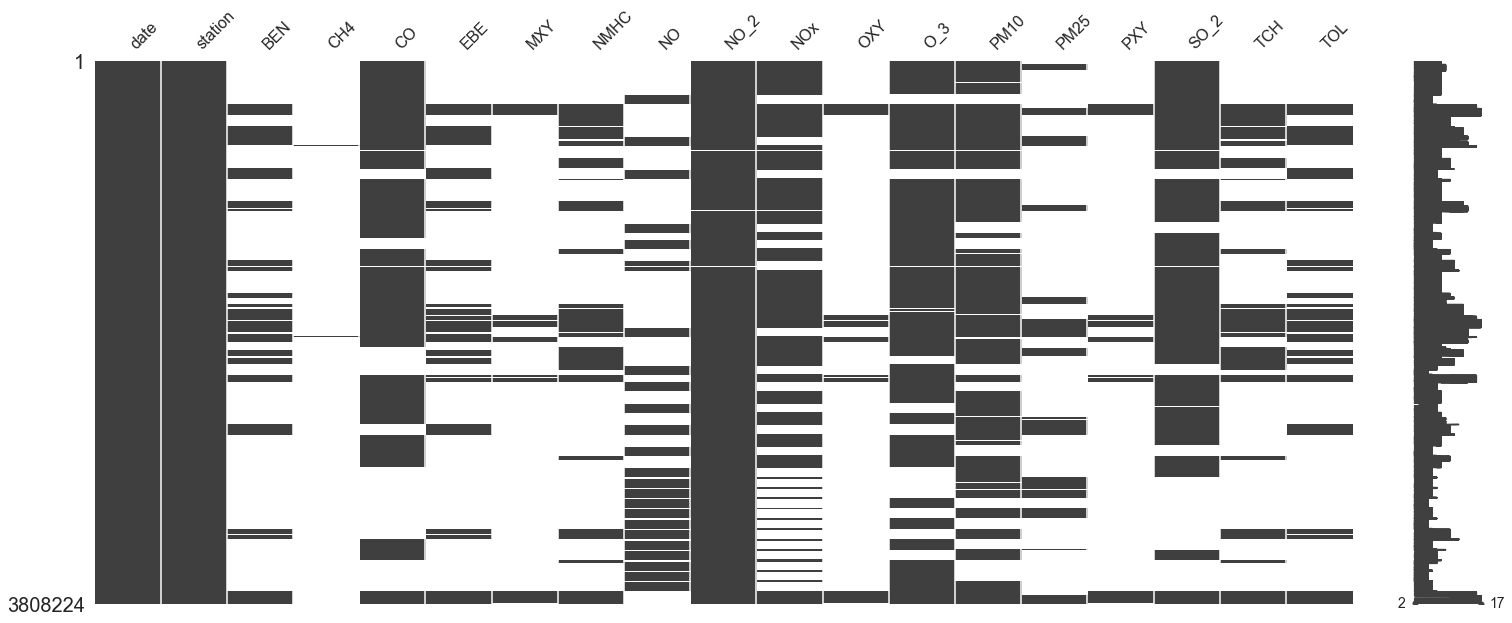

In [5]:
msno.matrix(frame);

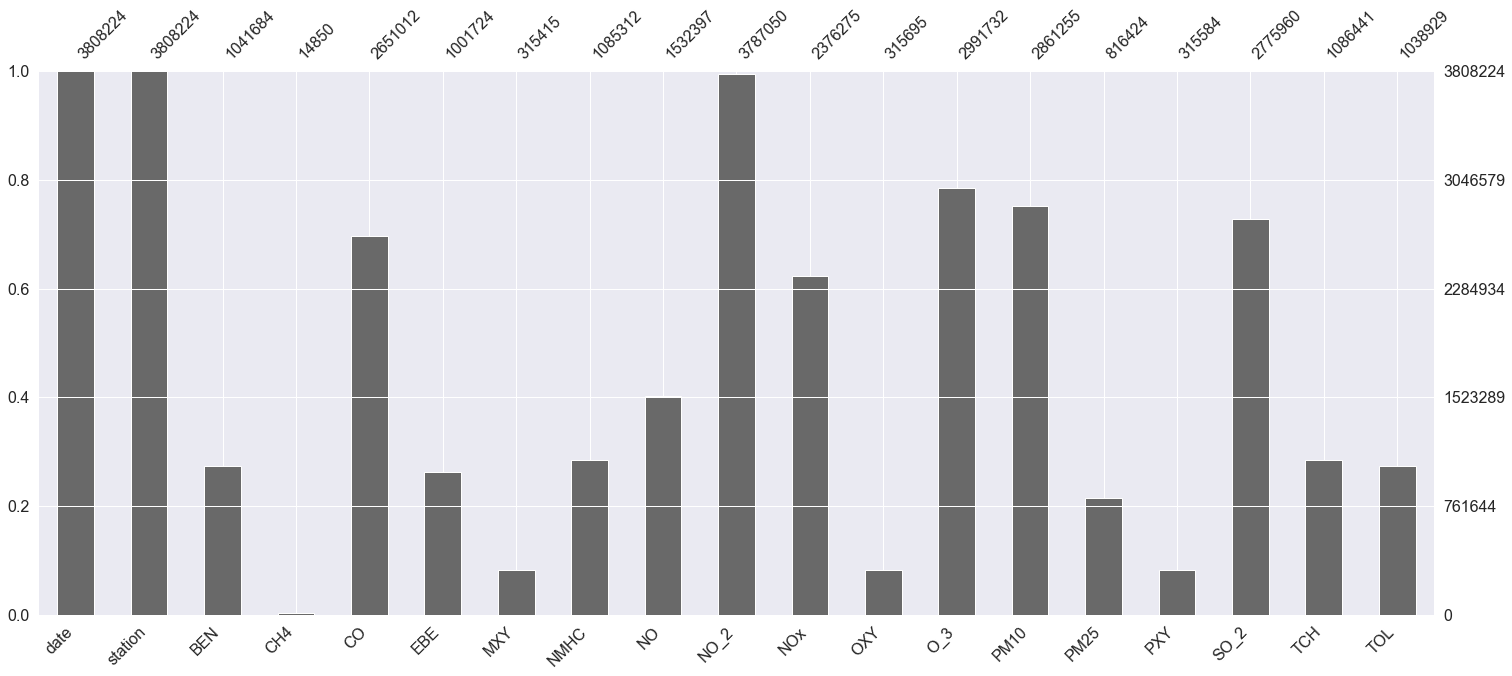

In [6]:
msno.bar(frame);

We are going to focus on the tropospheric ozone concentration so let´s get those data. 

Based on extensive scientific evidence about the effects of ozone on public health and welfare, on October 1, 2015, EPA strengthened the ground-level ozone standard to 0.070 ppm, averaged over an 8-hour period. This standard is met at an air quality monitor when the 3-year average of the annual fourth-highest daily maximum 8-hour average ozone concentration is less than or equal to 0.070 ppm. We need to do this transformation of the data:

In [7]:
cols = ['date', 'station', 'O_3']
o3 = frame[cols]

o3['date'] = pd.to_datetime(o3['date'])
o3['ppb'] = 24.45*o3['O_3'] /48

o3.head()

,date,station,O_3,ppb
108960,2001-01-02 01:00:00,28079001,NaN,NaN
108986,2001-01-02 02:00:00,28079001,NaN,NaN
109012,2001-01-02 03:00:00,28079001,NaN,NaN
109038,2001-01-02 04:00:00,28079001,NaN,NaN
109064,2001-01-02 05:00:00,28079001,NaN,NaN


In [8]:
# non-nulls per station
count_rows = pd.DataFrame(o3.groupby(['station']).O_3.count())
top3 = count_rows.sort_values('O_3', ascending=False).head(3)
top3

,O_3
station,
28079016,151131
28079024,149135
28079018,149067


In order to simplify our model, we are going to use the data from the station with no null data for tropospheric O3.

In [9]:
# select station with most data
o3_station = o3[o3.station == top3.index[0]]

# Calculate Eight-Hour Average Ozone Concentrations
o3_station['ppb_rolling'] = o3_station['ppb'].rolling(8).mean()

del o3_station['station']
del o3_station['O_3']
del o3_station['ppb']

o3_station = o3_station.sort_values("date")

o3_station.columns = ['ds', 'y']
o3_station.set_index('ds', inplace=True)

# Resample to daily max
o3_station = o3_station.resample('D').max()

# Any missing dates?
d = pd.DataFrame(pd.date_range(start= o3_station.index.min(), end= o3_station.index.max(), freq='D'))   

o3_station.reset_index(level=0, inplace=True)
o3_station = d.join(o3_station)
del o3_station['ds']

In [10]:
o3_station.columns = ['ds', 'y']

# fill na 
o3_station['y'].fillna(0, inplace=True)

In [11]:
o3_station.head()

,ds,y
0,2001-01-01,15.709762
1,2001-01-02,26.416824
2,2001-01-03,18.075172
3,2001-01-04,17.483024
4,2001-01-05,7.559125


In [12]:
o3_station.set_index('ds', inplace = True)
o3_station.head()

,y
ds,
2001-01-01,15.709762
2001-01-02,26.416824
2001-01-03,18.075172
2001-01-04,17.483024
2001-01-05,7.559125


Now, let´s see if our data are stationary:

In [13]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic            -5.092610
p-value                    0.000015
Lags Used                 31.000000
Observations Used       6298.000000
Critical Value (1%)       -3.431389
Critical Value (5%)       -2.861999
Critical Value (10%)      -2.567014
dtype: float64


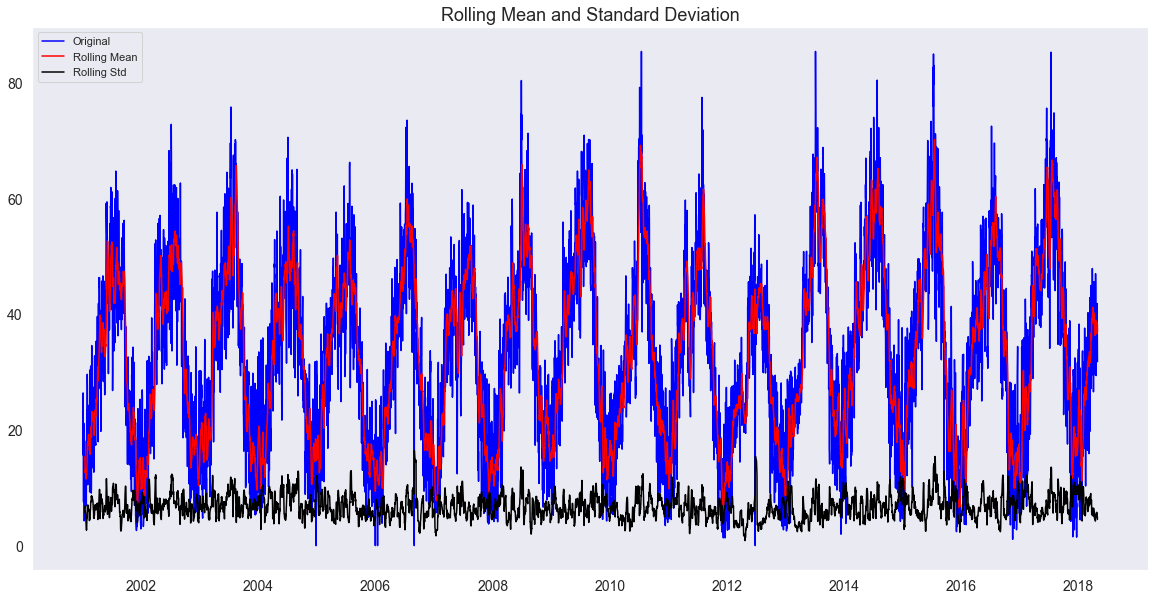

In [14]:
dftest(o3_station.y)

The p value allows us to reject the alternative hipothesis: our data are stationary

### 3. TRAIN-TEST SPLIT

In order to train our models, we need to train-test split our dataframe. Our test dataframe will contain the last 3 years.

In [15]:
# 3 years in hours
i = 3*365 

# Train test split 
train = o3_station[1:-i]
test = o3_station[-i:]

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5234 entries, 2001-01-02 to 2015-05-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       5234 non-null   float64
dtypes: float64(1)
memory usage: 81.8 KB


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2015-05-03 to 2018-05-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1095 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


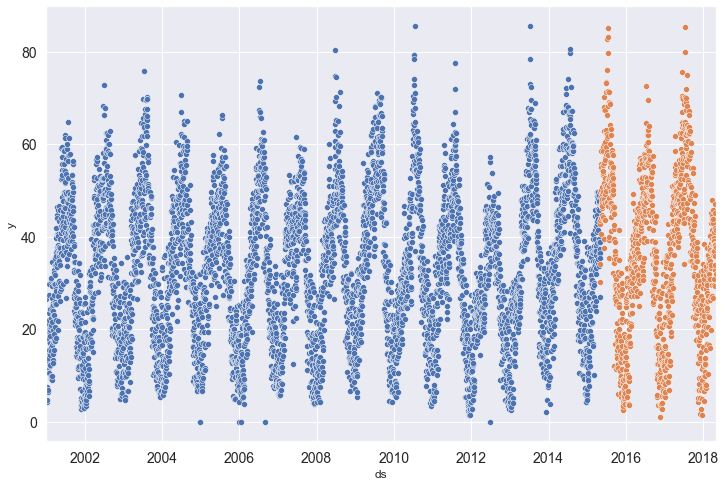

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

ax = sns.scatterplot(x=train.index, y=train.y)
ax = sns.scatterplot(x=test.index, y=test.y)

ax.axes.set_xlim(train.index.min(), test.index.max());

In order to get better results, we need to normalize our data:

In [18]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

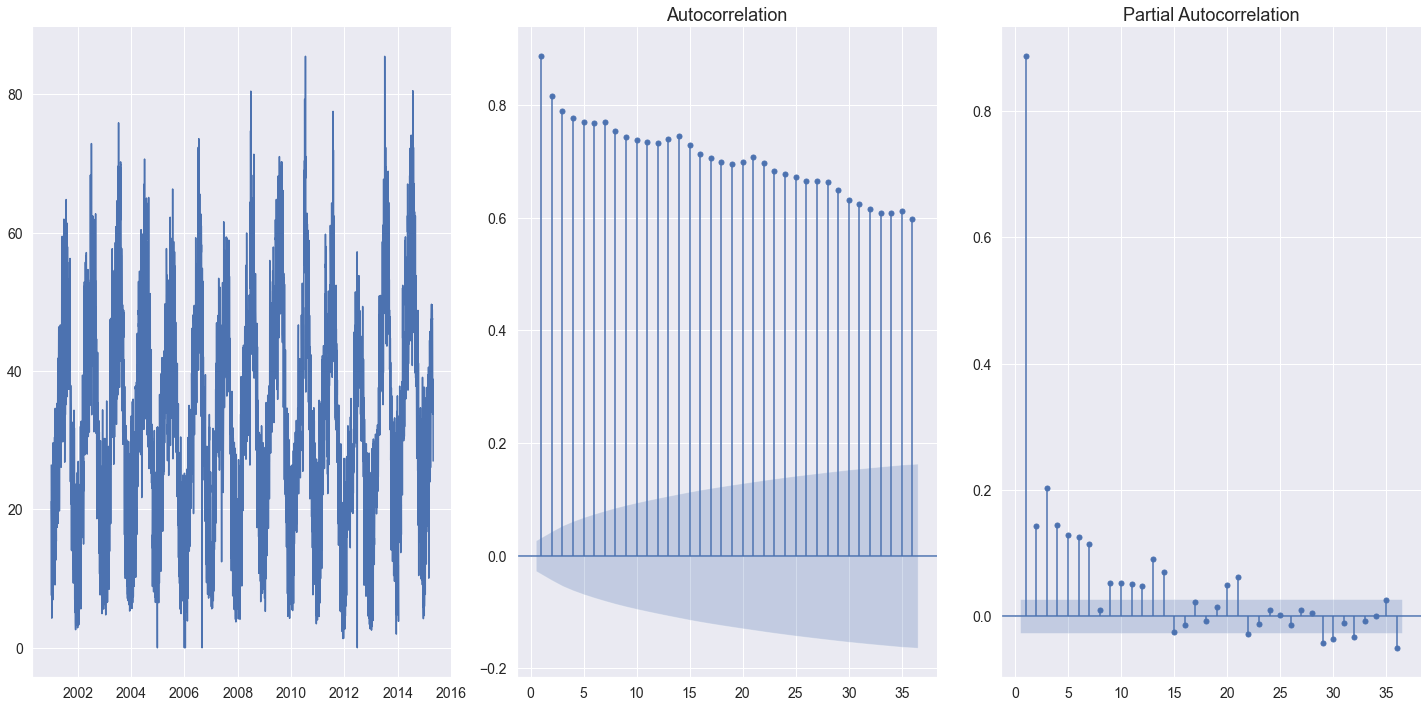

In [19]:
plots(train.y, lags=36);

We note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

In [20]:


train['y'] = np.log1p(train.y)
test['y'] = np.log1p(test.y)

train.head()

,y
ds,
2001-01-02,3.311157
2001-01-03,2.948388
2001-01-04,2.916853
2001-01-05,2.146998
2001-01-06,3.099670


### 4. SARIMA MODEL

**4.1. STATIONARITY CHECK AND SEASONAL DECOMPOSITION**


Dickey–Fuller test: p=0.000069


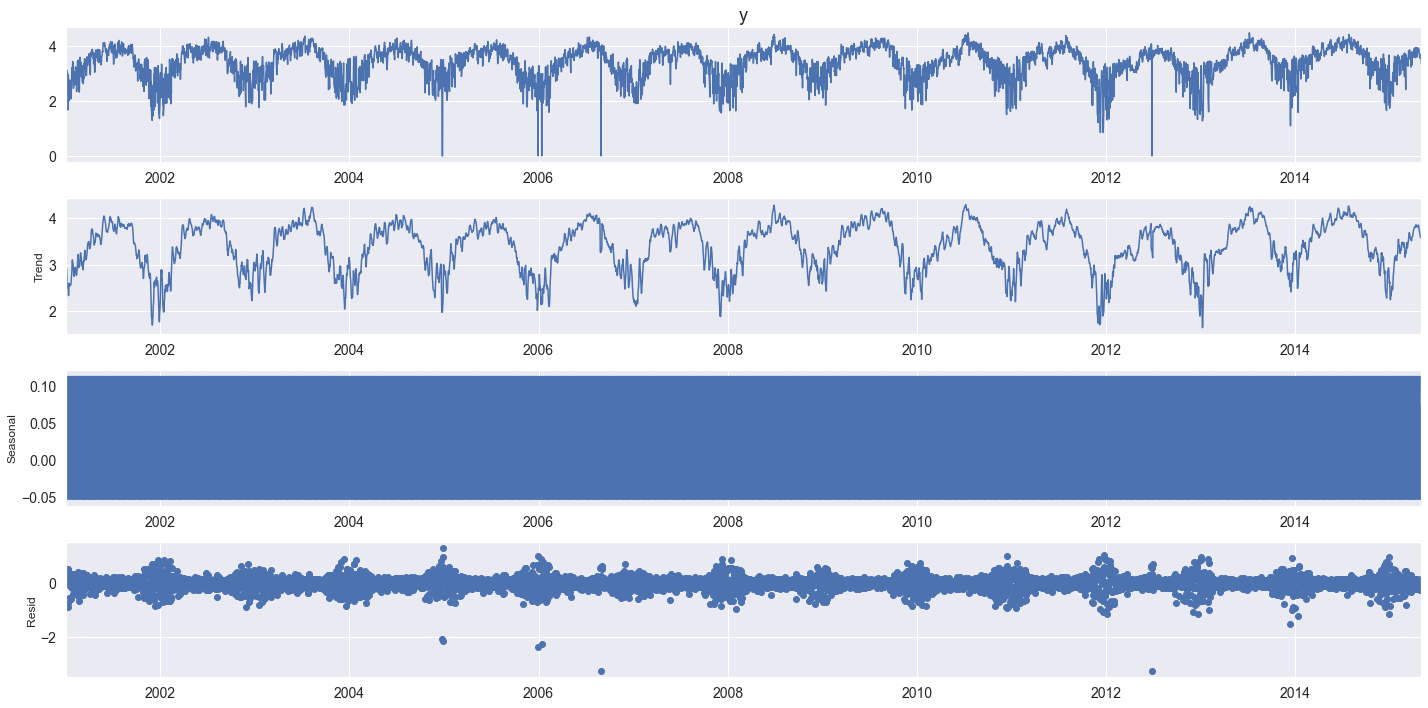

In [22]:
seasonal_decompose(train.y, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(train.y)[1])

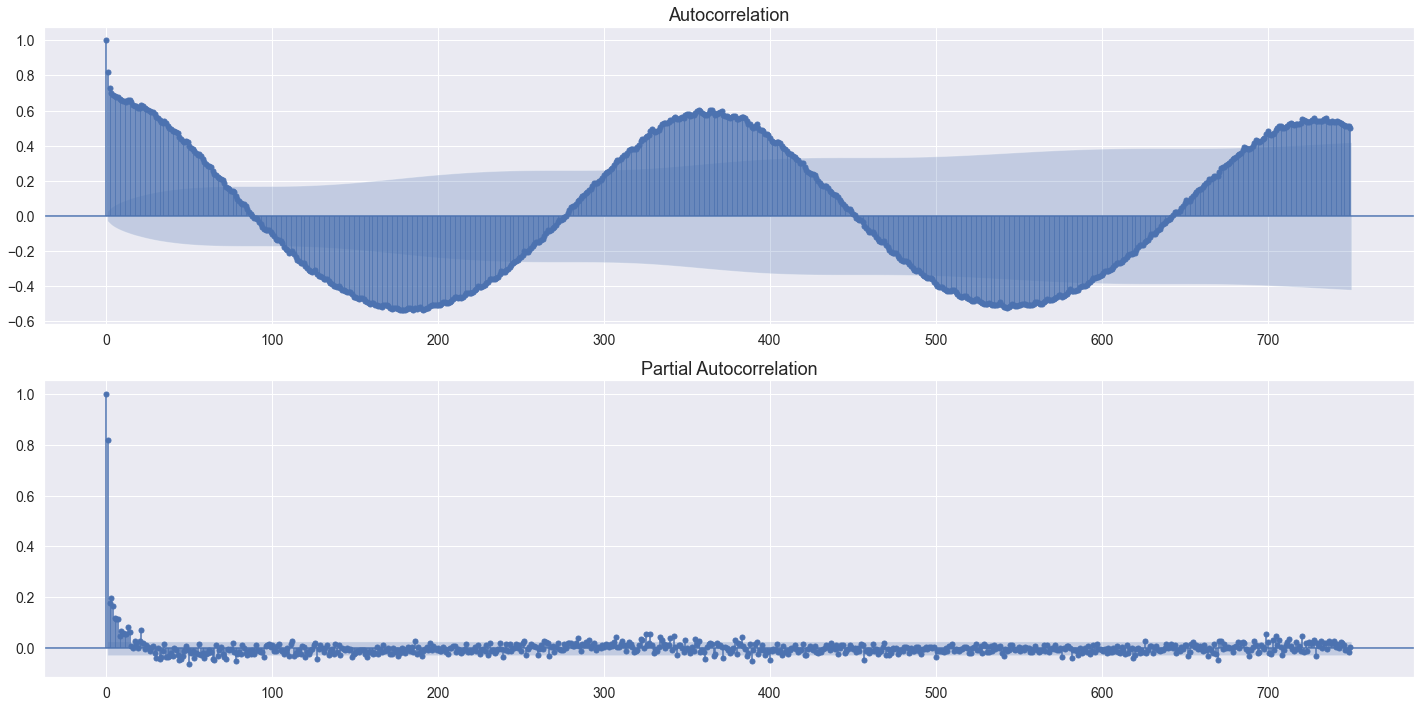

In [23]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)

# Plot the autocorrelation function
plot_acf(train.y[0:].values.squeeze(), lags=750, ax=ax)
ax = plt.subplot(212)
plot_pacf(train.y[0:].values.squeeze(), lags=750, ax=ax)
plt.tight_layout()

We saw before, our data are stationary.
Let´s see the best values for our model

**4.2. MODELING**

We are going to use the auto_arima function to get the optimal parameters for our model.

In [25]:
# Model Selection
import pmdarima as pm

automodel = pm.auto_arima(train.y, start_p=0, start_q=0,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=6138.295, Time=4.26 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=7329.418, Time=1.27 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=4647.362, Time=7.33 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=4656.270, Time=8.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=7327.533, Time=0.38 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=6054.507, Time=1.12 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=4164.449, Time=20.16 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=78.07 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=33.78 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=6042.307, Time=9.77 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4151.285, Time=27.23 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=4649.353, Time=9.04 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=83.54 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=36.89 sec
 ARIMA(3,0,0)(2,1,0)[12] intercep

In [26]:
print('order: ',automodel.order)
print('seasonal order: ',automodel.seasonal_order)

order:  (2, 0, 2)
seasonal order:  (2, 1, 0, 12)


In [28]:
sar_model = sm.tsa.statespace.SARIMAX(train.y, 
                                order=(2,0,2), 
                                seasonal_order=(2,1,0,12), 
                                trend='c').fit()

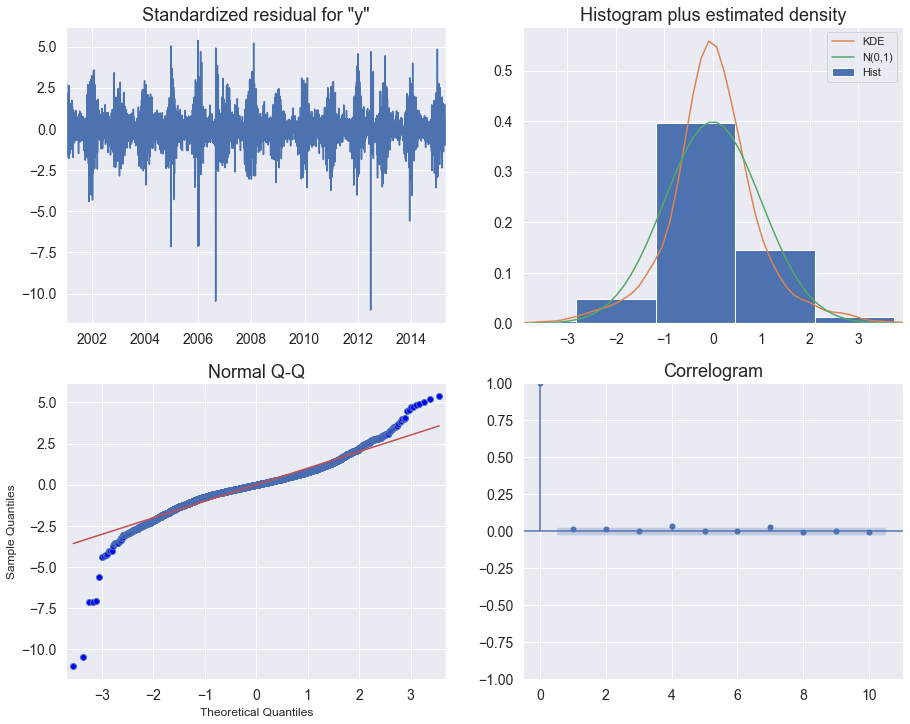

In [29]:
sar_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [30]:
test['yhat_SARIMA'] = sar_model.forecast(test.shape[0])
test.head()

,y,yhat_SARIMA
ds,,
2015-05-03,3.441832,3.621363
2015-05-04,3.557188,3.659629
2015-05-05,3.776436,3.771166
2015-05-06,3.799501,3.764907
2015-05-07,3.923959,3.806994


Let´s plot our prediction for the last 3 years and see how it looks like:

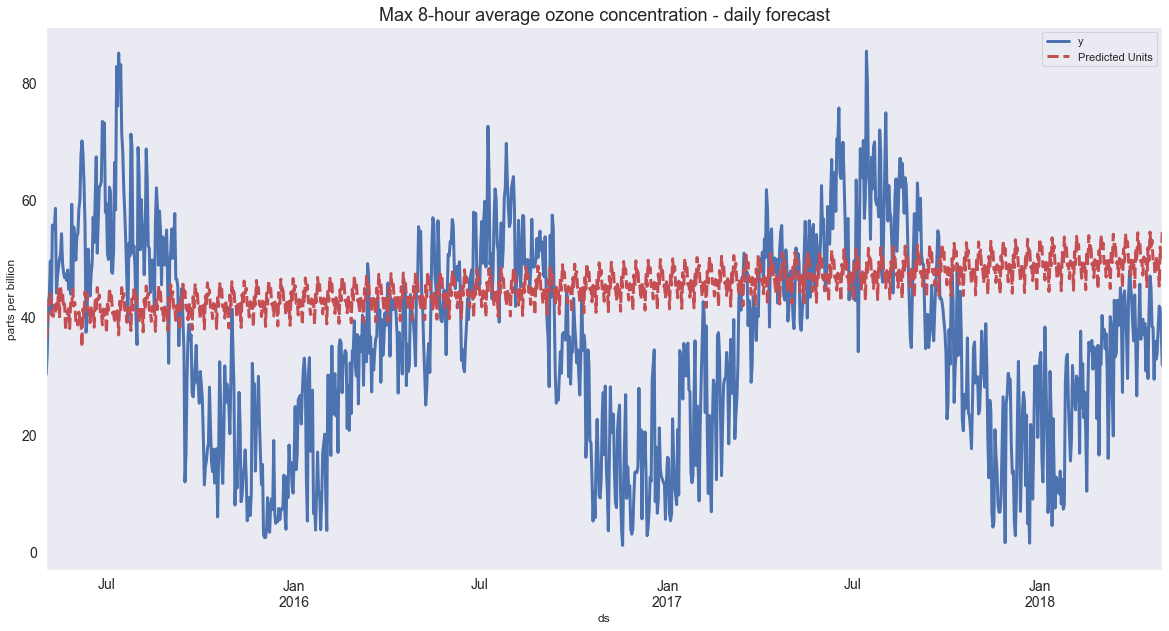

In [31]:
np.expm1(test.y).plot(linewidth=3)
np.expm1(test.yhat_SARIMA).plot(color='r', ls='--', label='Predicted Units', linewidth=3)

plt.legend()
plt.grid()
plt.title('Max 8-hour average ozone concentration - daily forecast')
plt.ylabel('parts per billion');

In [32]:
test['e'] = test.y - test.yhat_SARIMA

rmse = np.round(np.sqrt(np.mean(test.e**2)),2)
mape = np.round(np.mean(np.abs(100*test.e/test.y)), 2)
print('RMSE =', rmse)
print('MAPE =', mape, '%')

RMSE = 0.75
MAPE = 20.19 %


### 5. LONG SHORT-TERM MEMORY MODEL

In [39]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error



**5.1. SPLIT THE DATA AND SCALING**

We are going to split the data into train and test using the following function:

In [40]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(24*n_days):] 


def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

With the **get_train_test_data** utility function in hand, we're all set to extract keras-friendly arrays and start training LSTM models. We run this function in the cell below. We use the last 56 days of the o3_station series, and will train a model that takes in 12 time steps in order to predict the next time step. 

In [41]:
series_days = 56
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(o3_station, 'y', series_days, 
                         input_hours, test_hours))

**5.2. LSTM MODEL**

Now, we use the funtion below to train our LSTM model:

In [42]:

def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [43]:
model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000) 

In [44]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

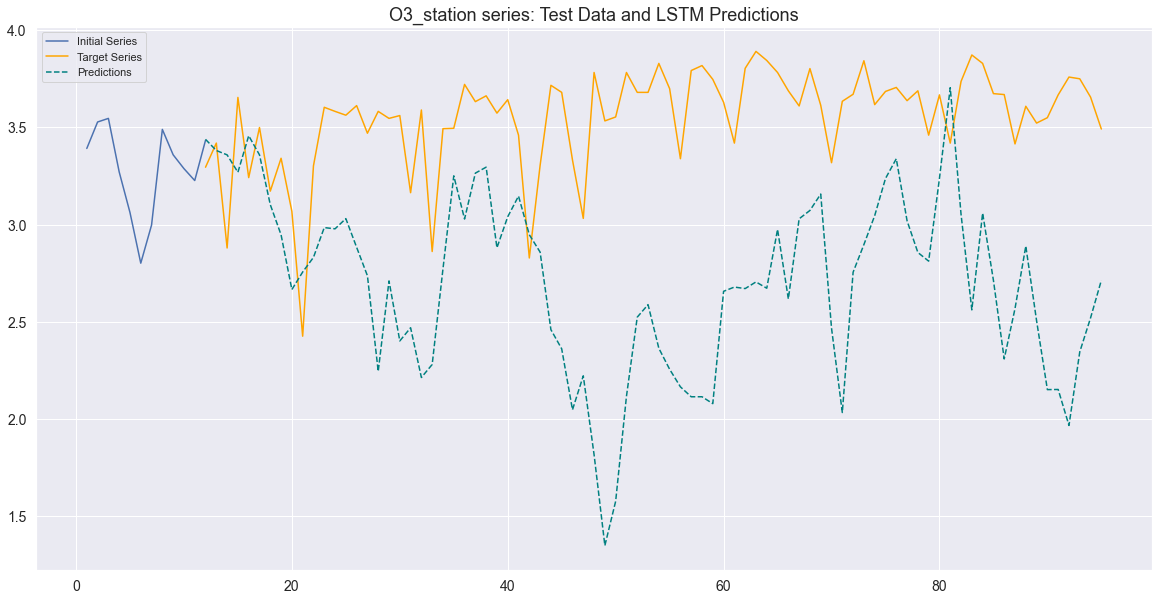

In [45]:
predict_and_plot(test_X_init, test_y, model, 
                 'O3_station series: Test Data and LSTM Predictions')

### 6. RNN MODEL

And now, we are going to use the following function to train  RNN model:

In [52]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [53]:
model = fit_SimpleRNN(train_X, train_y, cell_units=70, epochs=3000)

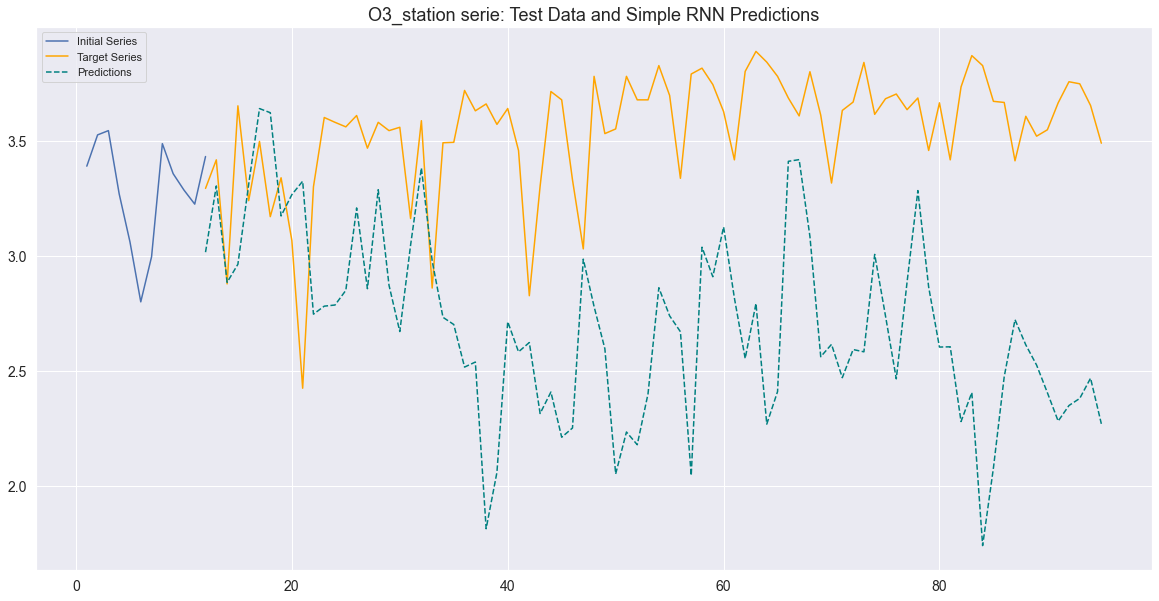

In [55]:
predict_and_plot(test_X_init, test_y, model,
                 'O3_station serie: Test Data and Simple RNN Predictions')

### 7. FURTHER EXPLORATION

Here are several suggestions for how you could explore these ideas further, leveraging the code we've implemented today:

* Try using longer chunks of the series we've looked at in this notebook for modeling (set series_days larger than 56), or modeling other series in the dataset.
* When training with more data, try increasing cell_units and running more training epochs.  
* Try using longer input sequences with LSTM, and predicting a wider range of test hours.